### Filtering the dataset samples before training the model

I manually listened to the dataset recordings and I observed that the noise is usually voices in the background and rustling. Thus I will need a low pass filter to cut it.

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from   scipy.io import wavfile
import scipy.signal as signalpy
import wave
import sys
import math
import contextlib
import IPython
import os
import librosa
import librosa.display
import pandas as pd
import sklearn.datasets as datasets
import shutil


### Useful functions

In [9]:
# from http://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def running_mean(x, windowSize):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[windowSize:] - cumsum[:-windowSize]) / windowSize

# from http://stackoverflow.com/questions/2226853/interpreting-wav-data/2227174#2227174
def interpret_wav(raw_bytes, n_frames, n_channels, sample_width, interleaved = True):

    if sample_width == 1:
        dtype = np.uint8 # unsigned char
    elif sample_width == 2:
        dtype = np.int16 # signed 2-byte short
    else:
        raise ValueError("Only supports 8 and 16 bit audio formats.")

    channels = np.frombuffer(raw_bytes, dtype=dtype)

    if interleaved:
        # channels are interleaved, i.e. sample N of channel M follows sample N of channel M-1 in raw data
        channels.shape = (n_frames, n_channels)
        channels = channels.T
    else:
        # channels are not interleaved. All samples from channel M occur before all samples from channel M-1
        channels.shape = (n_channels, n_frames)

    return channels


def extract_audio(fname, tStart=None, tEnd=None):
    with contextlib.closing(wave.open(fname,'rb')) as spf:
        sampleRate = spf.getframerate()
        ampWidth = spf.getsampwidth()
        nChannels = spf.getnchannels()
        nFrames = spf.getnframes()

        startFrame, endFrame, segFrames = get_start_end_frames(nFrames, sampleRate, tStart, tEnd)

        # Extract Raw Audio from multi-channel Wav File
        spf.setpos(startFrame)
        sig = spf.readframes(segFrames)
        spf.close()

        channels = interpret_wav(sig, segFrames, nChannels, ampWidth, True)

        return (channels, nChannels, sampleRate, ampWidth, nFrames)
    
def convert_to_mono(channels, nChannels, outputType):
    if nChannels == 2:
        samples = np.mean(np.array([channels[0], channels[1]]), axis=0)  # Convert to mono
    else:
        samples = channels[0]

    return samples.astype(outputType)

def get_start_end_frames(nFrames, sampleRate, tStart=None, tEnd=None):

    if tStart and tStart*sampleRate<nFrames:
        start = tStart*sampleRate
    else:
        start = 0

    if tEnd and tEnd*sampleRate<nFrames and tEnd*sampleRate>start:
        end = tEnd*sampleRate
    else:
        end = nFrames

    return (start,end,end-start)

def plot_specgram(samples, sampleRate, tStart=None, tEnd=None):
    plt.figure(figsize=(20,10))
    plt.specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def plot_audio_samples(title, samples, sampleRate, tStart=None, tEnd=None):
    if not tStart:
        tStart = 0

    if not tEnd or tStart>tEnd:
        tEnd = len(samples)/sampleRate

    f, axarr = plt.subplots(2, sharex=True, figsize=(20,10))
    axarr[0].set_title(title)
    axarr[0].plot(np.linspace(tStart, tEnd, len(samples)), samples)
    axarr[1].specgram(samples, Fs=sampleRate, NFFT=1024, noverlap=192, cmap='nipy_spectral', xextent=(tStart,tEnd))
    #get_specgram(axarr[1], samples, sampleRate, tStart, tEnd)

    axarr[0].set_ylabel('Amplitude')
    axarr[1].set_ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    plt.show()

### Filters

In [10]:
def fir_low_pass(samples, fs, fL, N, outputType):
    # Referece: https://fiiir.com

    fL = fL / fs

    # Compute sinc filter.
    h = np.sinc(2 * fL * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

def fir_high_pass(samples, fs, fH, N, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs

    # Compute sinc filter.
    h = np.sinc(2 * fH * (np.arange(N) - (N - 1) / 2.))
    # Apply window.
    h *= np.hamming(N)
    # Normalize to get unity gain.
    h /= np.sum(h)
    # Create a high-pass filter from the low-pass filter through spectral inversion.
    h = -h
    h[int((N - 1) / 2)] += 1
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)
    return s

def fir_band_reject(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fL.
    hlpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hlpf *= np.blackman(NL)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fH.
    hhpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hhpf *= np.blackman(NH)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NH - 1) / 2)] += 1
    # Add both filters.
    if NH >= NL:
        h = hhpf
        h[int((NH - NL) / 2) : int((NH - NL) / 2 + NL)] += hlpf
    else:
        h = hlpf
        h[int((NL - NH) / 2) : int((NL - NH) / 2 + NH)] += hhpf
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

def fir_band_pass(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hlpf *= np.blackman(NH)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hhpf *= np.blackman(NL)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NL - 1) / 2)] += 1
    # Convolve both filters.
    h = np.convolve(hlpf, hhpf)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

def butter_low_pass(samples, fs, fL, order, outputType):
    # Normalize the cutoff frequency
    fN = fs / 2
    fL_norm = fL / fN

    # Calculate the Butterworth filter coefficients
    b, a = signalpy.butter(order, fL_norm, btype='low')

    # Apply the filter to the signal
    s = signalpy.lfilter(b, a, samples).astype(outputType)

    return s

### Creating "filtered_data" folder and filtering every file

Normally, the heart sounds frequencies are between 25Hz and 200Hz, but the murmurs can have higher frequencies (up to 500Hz). Thus, I chose to use a low pass filter, taking into consideration that there is no sound below 25Hz.

In [51]:
# Set the directory paths
input_dir   = 'phonocardiogram_dataset/training_data/training_data'
output_dir  = 'phonocardiogram_dataset/training_data/filtered_data'
folder_name = "phonocardiogram_dataset/training_data/filtered_data"

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Set the filter parameters
fL = 500
order = 19
outputType = np.int16

# Iterate over all files in the input directory

for file_name in os.listdir(input_dir):
    # Check if the file is a .wav file
    if file_name.endswith('.wav'):
        # Set the input and output file paths
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, file_name[:-4] + '_filtered.wav') # I added the _filtered suffix to the output file name
        
        # Load the audio file and apply the filter
        sample_rate, samples = wavfile.read(input_path)
        sample_low_pass = butter_low_pass(samples, sample_rate, fL, order, outputType)
        
        # Save the filtered audio to a new file
        wavfile.write(output_path, sample_rate, sample_low_pass)

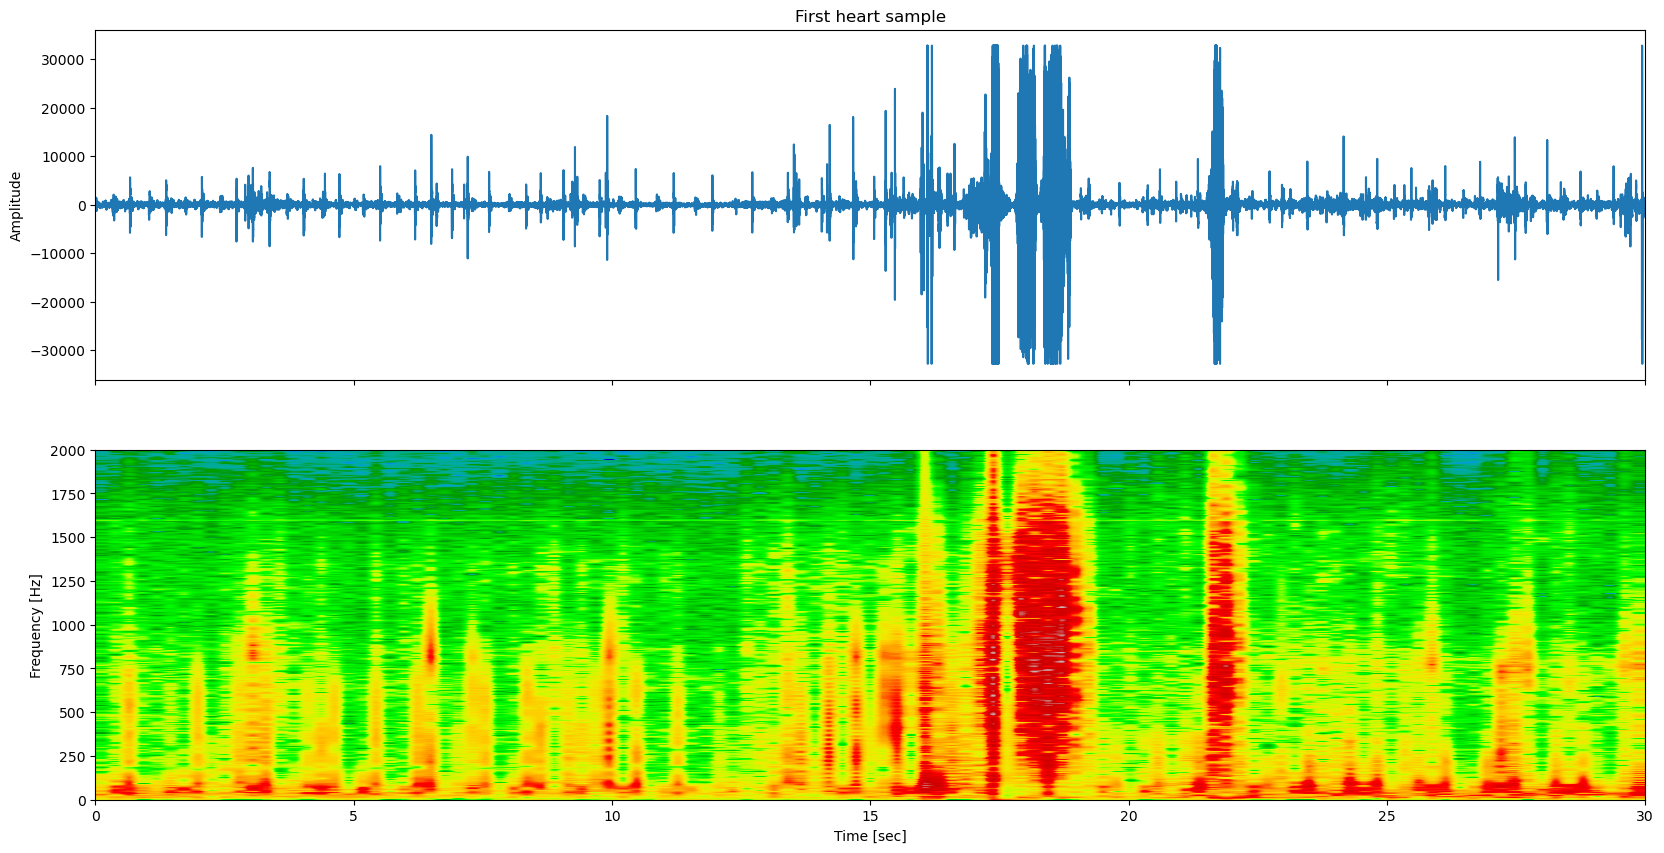

In [37]:
# 2530_AV.wav

tStart = 0
tEnd = 30

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio('phonocardiogram_dataset/training_data/training_data/2530_AV.wav', tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

plot_audio_samples("First heart sample", samples, sampleRate, tStart, tEnd)

In [38]:
audio_file = 'phonocardiogram_dataset/training_data/training_data/2530_AV.wav'

IPython.display.Audio( audio_file )

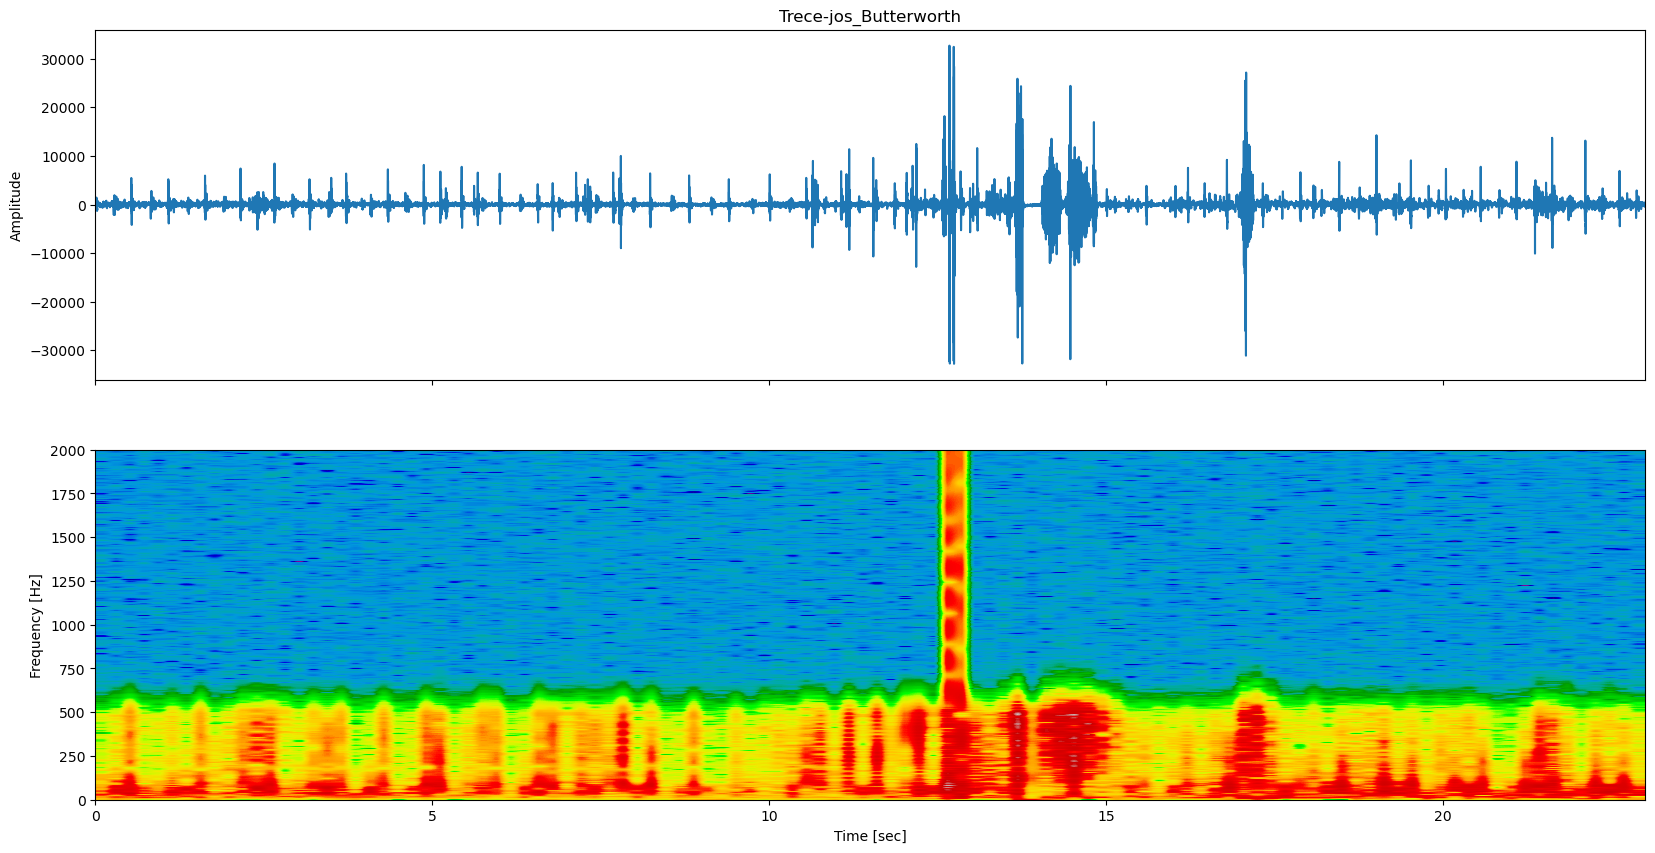

In [61]:
audio_file = 'phonocardiogram_dataset/training_data/training_data/2530_AV.wav'

tStart=0
tEnd=23

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio(audio_file, tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

#Trece jos

# sample_low_pass = fir_low_pass(samples, sampleRate , 200 , 551, np.int16)
sample_low_pass = butter_low_pass(samples, sampleRate , 500 , 19, np.int16)
plot_audio_samples("Trece-jos_Butterworth", sample_low_pass, sampleRate, tStart, tEnd)

# sample_low_pass_amplified =  np.multiply(sample_low_pass, 4)

# plot_audio_samples("Amplificat", sample_low_pass_amplified, sampleRate, tStart, tEnd)

wavfile.write('phonocardiogram_dataset/training_data/filtered_data/2530_AV_filtered.wav', sampleRate, sample_low_pass)



IPython.display.Audio( 'phonocardiogram_dataset/training_data/filtered_data/2530_AV_filtered.wav' )

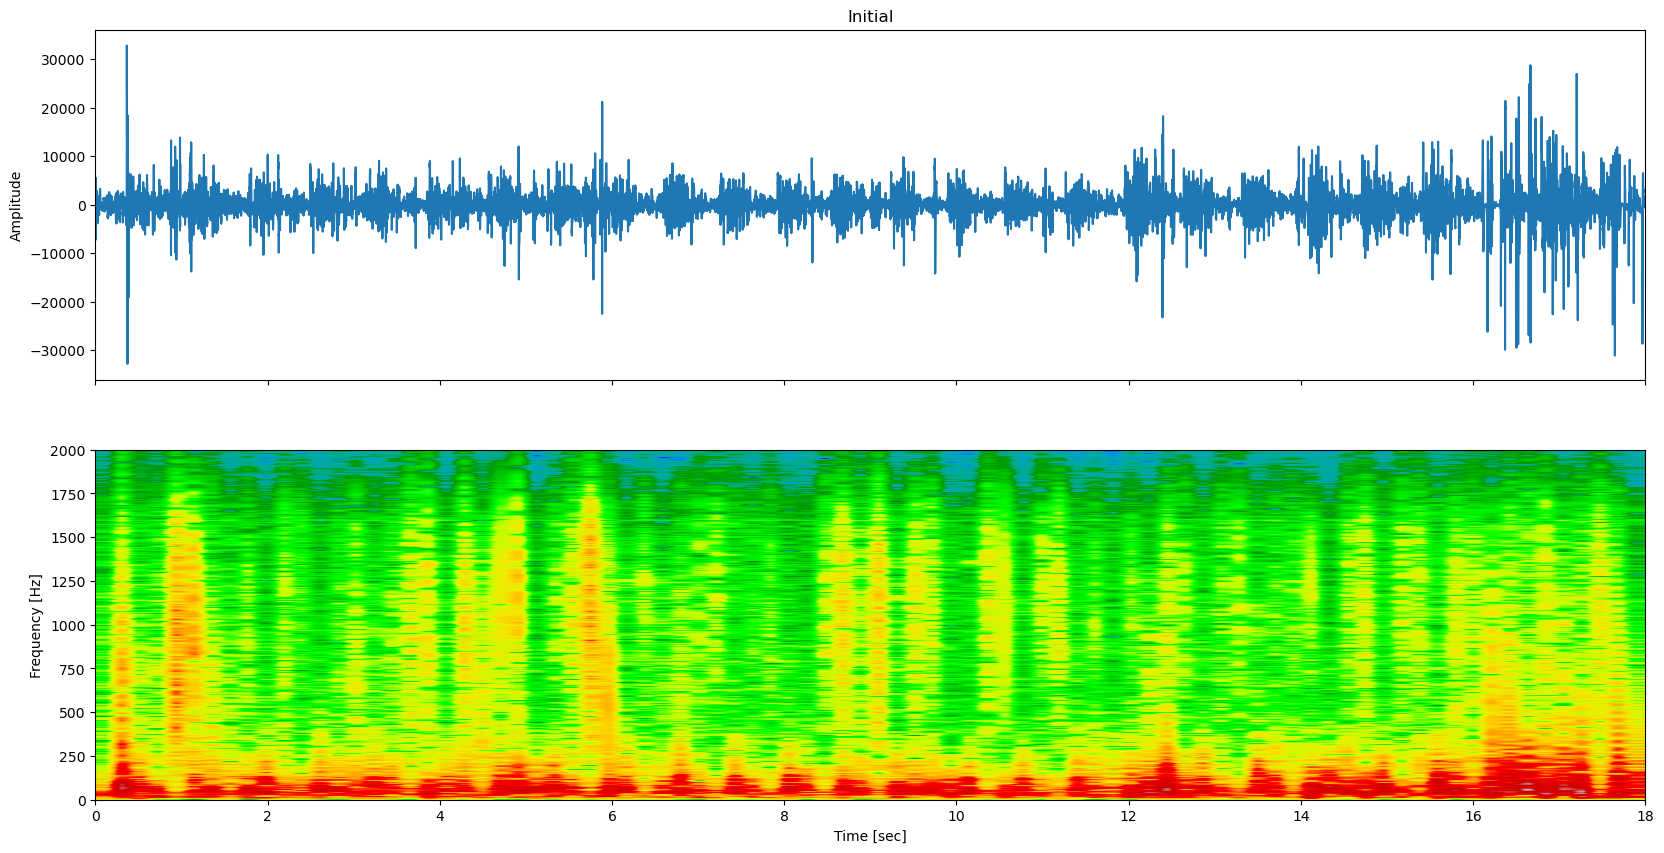

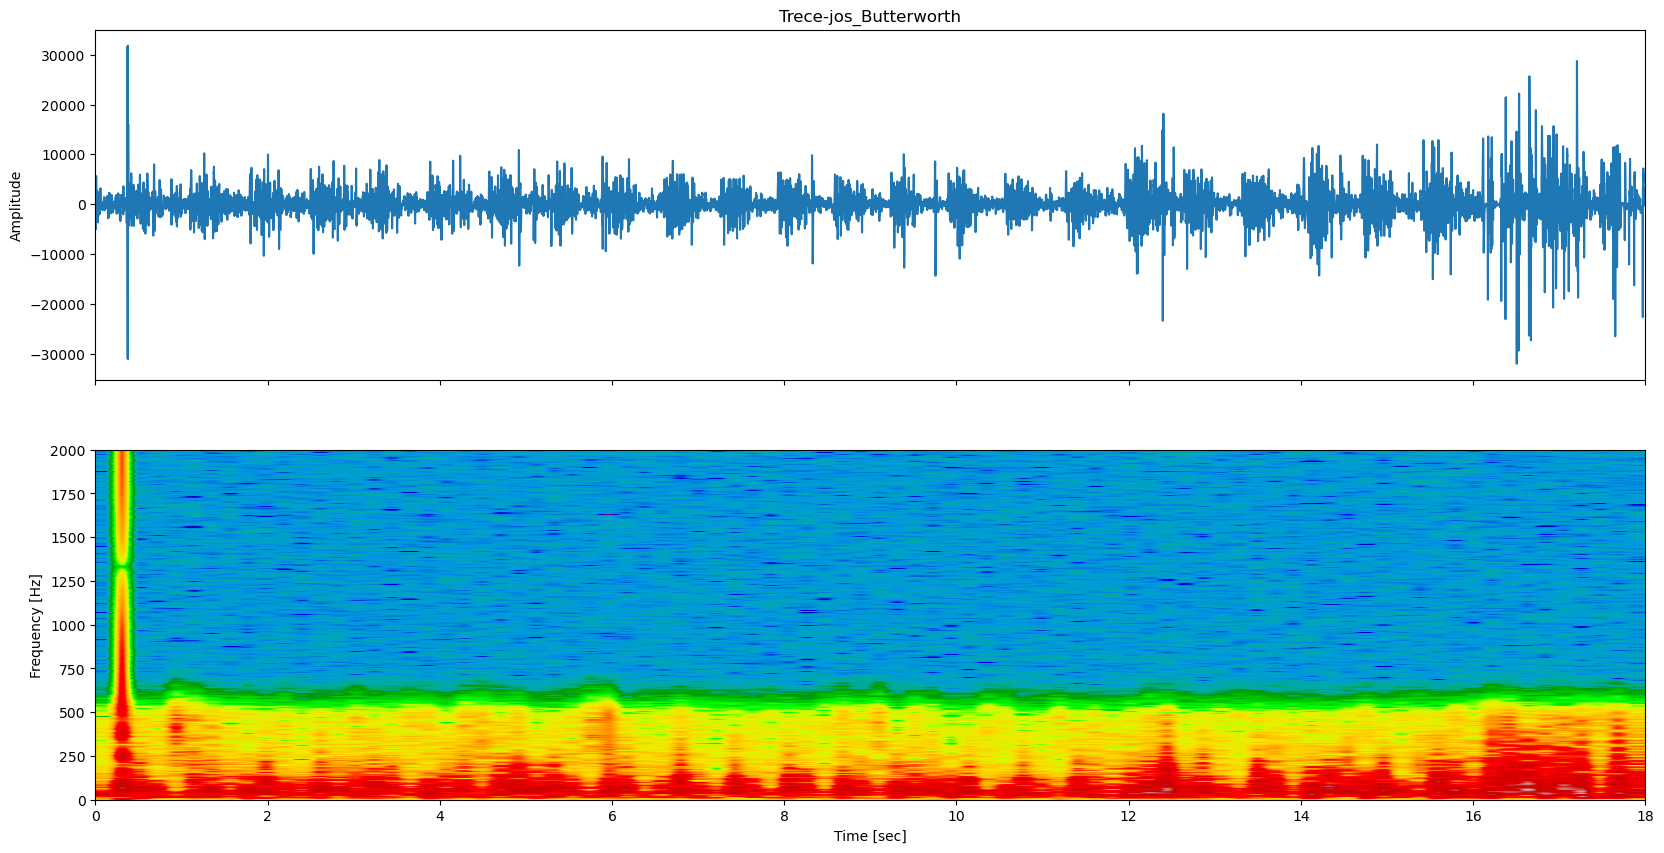

In [50]:
audio_file = 'phonocardiogram_dataset/training_data/training_data/9979_AV.wav'

tStart=0
tEnd=18

channels, nChannels, sampleRate, ampWidth, nFrames = extract_audio(audio_file, tStart, tEnd)
samples = convert_to_mono(channels, nChannels, np.int16)

plot_audio_samples("Initial", samples, sampleRate, tStart, tEnd)

#Trece jos

# sample_low_pass = fir_low_pass(samples, sampleRate , 200 , 551, np.int16)
sample_low_pass = butter_low_pass(samples, sampleRate , 500 , 19, np.int16)
plot_audio_samples("Trece-jos_Butterworth", sample_low_pass, sampleRate, tStart, tEnd)

# sample_low_pass_amplified =  np.multiply(sample_low_pass, 4)

# plot_audio_samples("Amplificat", sample_low_pass_amplified, sampleRate, tStart, tEnd)

wavfile.write('phonocardiogram_dataset/training_data/filtered_data/9979_AV_filtered.wav', sampleRate, sample_low_pass)



IPython.display.Audio( 'phonocardiogram_dataset/training_data/filtered_data/9979_AV_filtered.wav' )

### Testing the difference between filtered and non-filtered phonocardiograms

In [16]:
input_dir = 'phonocardiogram_dataset/training_data/training_data'
output_dir = 'phonocardiogram_dataset/training_data/filtered_data'
file_name = '13918_AV'

IPython.display.Audio(os.path.join(input_dir , file_name + '.wav'))

In [17]:
IPython.display.Audio(os.path.join(output_dir , file_name + '_filtered.wav'))

### Importing the dataset

In [184]:
# root_path = '/C/Users/Ema/Desktop/Phonocardiogram Analysis/'
pacient_info_initial = pd.read_csv('phonocardiogram_dataset/training_data.csv')
# Filtering pacient data. I will see if I need any of the personal information later (like sex, age, pregnancy status etc.) 
# Most probably I will drop the "Campaign" column anyway, because it is not relevant for the analysis.
# AdditionalID column is empty unless the same patient is tested multiple times in the dataset (obviously, it appears the next time with a different ID). I will keep it for now in case it is useful.
pacient_info_initial = pacient_info_initial.drop(columns=["Age", "Sex" , "Height" , "Weight", "Pregnancy status" , "Campaign"])

display(pacient_info_initial)


,Patient ID,Locations,Murmur,Murmur locations,Most audible location,Systolic murmur timing,Systolic murmur shape,Systolic murmur grading,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Additional ID
0,2530,AV+PV+TV+MV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9979,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,Holosystolic,Diamond,III/VI,High,Harsh,NaN,NaN,NaN,NaN,NaN,NaN
2,9983,AV+PV+TV+MV,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13918,AV+PV+TV+MV,Present,TV,TV,Holosystolic,Plateau,I/VI,Low,Blowing,NaN,NaN,NaN,NaN,NaN,NaN
4,14241,AV+PV+TV+MV,Present,AV+MV+PV+TV,PV,Early-systolic,Plateau,II/VI,Low,Harsh,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,85340,AV+PV+TV+MV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,85341,AV+PV+TV+MV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,85343,AV+PV+TV+MV,Present,MV+TV,TV,Early-systolic,Plateau,I/VI,Low,Blowing,NaN,NaN,NaN,NaN,NaN,NaN
940,85345,AV+PV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Copying only the .wav files to a new folder

In [89]:
input_dir   = 'phonocardiogram_dataset/training_data/training_data/'
output_dir  = 'phonocardiogram_dataset/training_data/training_data_wavs/'




if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# iterate over all the files in the training_data folder
for file_name in os.listdir(input_dir):
    if file_name.endswith(".wav"):
        # construct the source and destination paths
        src_path = os.path.join(input_dir, file_name)
        dst_path = os.path.join(output_dir, file_name)
        # copy the file to the new folder
        shutil.copy(src_path, dst_path)

### Converting .wav files to floating point time series with librosa

In [132]:
input_dir   = 'phonocardiogram_dataset/training_data/training_data_wavs/'
signals = []
patient_IDs = []
auscultation_locations = []

for file_name in os.listdir(input_dir):
    signal, sample_rate = librosa.load(input_dir + file_name, sr=1200)
    signals.append(signal)
    patient_IDs.append(int((file_name.split('.')[0]).split('_')[0]))
    auscultation_locations.append((file_name.split('.')[0]).split('_')[1])


### Creating the pandas Dataframe with the converted signals

In [189]:
signal_dataframe = pd.DataFrame({'patient_id': patient_IDs,
                          'current_auscultation_location': auscultation_locations,
                          'signal': signals},
                         columns=['patient_id', 'current_auscultation_location' , 'signal'])

# display(signal_dataframe)

pacient_info_initial['count_auscultation_locations'] = 0


# I want to create the final dataframe concatenating the pacient_info_initial dataframe with the signal_dataframe dataframe.
# For doing that, I need to add 2 more columns:
# 1. count_auscultation_locations - the number of auscultation locations for each patient
# 2. signal - each signal for each patient
# 3. current_auscultation_location - the current auscultation location for each signal (there could be more for each patient)

for index, row in pacient_info_initial.iterrows():
    pacient_info_initial.at[index, 'count_auscultation_locations'] = len(row['Locations'].split('+'))


# IT HAS TO BE USED ONLY ONCE. OTHERWISE, IT WILL MULTIPLY THE ROWS EACH TIME IT IS RUN. - Final no. of rows = 3163
# pacient_info_initial = pacient_info_initial.loc[pacient_info_initial.index.repeat(pacient_info_initial.count_auscultation_locations)]
# pacient_info_initial.reset_index(drop=True,inplace=True)


pcg_dataframe = pd.concat([pacient_info_initial.reset_index(drop=True), signal_dataframe.sort_values(by='patient_id').reset_index(drop=True)], axis=1)

pcg_dataframe = pcg_dataframe.drop(columns=['patient_id' , 'count_auscultation_locations'])
# pcg_dataframe.columns

# For comparison - It seems correct
display(pcg_dataframe)
display(signal_dataframe.sort_values(by='patient_id').reset_index(drop=True))

if not os.path.exists('arrays/'):
    os.makedirs('arrays/')

np.save('arrays/pcg_dataframe.npy', pcg_dataframe.to_numpy())


,Patient ID,Locations,Murmur,Murmur locations,Most audible location,Systolic murmur timing,Systolic murmur shape,Systolic murmur grading,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Additional ID,current_auscultation_location,signal
0,2530,AV+PV+TV+MV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV,"[0.044283558, 0.08357305, 0.08483126, 0.079908..."
1,2530,AV+PV+TV+MV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PV,"[0.03783802, 0.06029642, 0.05549384, 0.0629868..."
2,2530,AV+PV+TV+MV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MV,"[0.18855691, 0.04248511, -0.017912444, 0.01127..."
3,2530,AV+PV+TV+MV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AV,"[0.006233137, -0.0059207836, -0.016664337, 0.0..."
4,9979,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,Holosystolic,Diamond,III/VI,High,Harsh,NaN,NaN,NaN,NaN,NaN,NaN,TV,"[-0.10014393, -0.82379806, -0.6746199, -0.4551..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3158,85345,AV+PV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PV,"[0.0065461225, 0.017596282, 0.0039989054, 0.02..."
3159,85345,AV+PV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AV,"[0.030420281, 0.00832418, -0.02191807, -0.0226..."
3160,85349,AV+PV+TV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AV,"[0.002057871, -0.008989884, 0.0024980423, 0.00..."
3161,85349,AV+PV+TV,Absent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PV,"[0.07421318, 0.05925179, 0.005897636, -0.05330..."


,patient_id,current_auscultation_location,signal
0,2530,TV,"[0.044283558, 0.08357305, 0.08483126, 0.079908..."
1,2530,PV,"[0.03783802, 0.06029642, 0.05549384, 0.0629868..."
2,2530,MV,"[0.18855691, 0.04248511, -0.017912444, 0.01127..."
3,2530,AV,"[0.006233137, -0.0059207836, -0.016664337, 0.0..."
4,9979,TV,"[-0.10014393, -0.82379806, -0.6746199, -0.4551..."
...,...,...,...
3158,85345,PV,"[0.0065461225, 0.017596282, 0.0039989054, 0.02..."
3159,85345,AV,"[0.030420281, 0.00832418, -0.02191807, -0.0226..."
3160,85349,AV,"[0.002057871, -0.008989884, 0.0024980423, 0.00..."
3161,85349,PV,"[0.07421318, 0.05925179, 0.005897636, -0.05330..."
